In [1]:
!nvidia-smi

Mon Aug  4 20:50:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 87.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install python-dotenv

In [6]:
from dotenv import load_dotenv

# Path to your .env in Drive
env_path = '/content/drive/MyDrive/ML Projects/Real-Time Object Detection in Autonomous Vehicles_YOLOv12/.env'
load_dotenv(env_path)

api_key = os.getenv('API_KEY')

## Download dataset from Roboflow Universe

In [7]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)
dataset = version.download("yolov12")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Self-Driving-Car-3 in yolov12:: 100%|██████████| 59606/59606 [00:11<00:00, 5223.05it/s] 


In [8]:
!ls {dataset.location}

data.yaml  export  README.dataset.txt  README.roboflow.txt


In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 11
names: ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']

roboflow:
  workspace: roboflow-gw7yv
test: ../test/images
train: ../train/images
val: ../valid/images


In [11]:
import os
import shutil
import random

def split_dataset(source_path, target_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)

    images_dir = os.path.join(source_path, "images")
    labels_dir = os.path.join(source_path, "labels")

    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    random.shuffle(image_files)

    total = len(image_files)
    train_split = int(total * train_ratio)
    val_split = int(total * (train_ratio + val_ratio))

    splits = {
        "train": image_files[:train_split],
        "valid": image_files[train_split:val_split],
        "test": image_files[val_split:]
    }

    for split in splits:
        for subfolder in ["images", "labels"]:
            os.makedirs(os.path.join(target_path, split, subfolder), exist_ok=True)

        for img_file in splits[split]:
            label_file = img_file.replace(".jpg", ".txt")
            shutil.copy(os.path.join(images_dir, img_file),
                        os.path.join(target_path, split, "images", img_file))
            shutil.copy(os.path.join(labels_dir, label_file),
                        os.path.join(target_path, split, "labels", label_file))

    print(f"✅ Split completed:\nTrain: {len(splits['train'])}, Valid: {len(splits['valid'])}, Test: {len(splits['test'])}")



split_dataset("/content/datasets/Self-Driving-Car-3/export","/content/datasets/Self-Driving-Car-3")


✅ Split completed:
Train: 20860, Valid: 4470, Test: 4470


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov12s.pt")

results = model.train(data=f'{dataset.location}/data.yaml', epochs=5)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 17.8M/17.8M [00:00<00:00, 79.3MB/s]


New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

100%|██████████| 755k/755k [00:00<00:00, 33.2MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 16.6MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/Self-Driving-Car-3/train/labels... 20860 images, 2437 backgrounds, 0 corrupt: 100%|██████████| 20860/20860 [00:09<00:00, 2114.58it/s]

train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478897760163798179_jpg.rf.5Pzrj3Eg3vZuyl7ztKAt.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478897760163798179_jpg.rf.98623be50b02ff17d58f89fddf7a0c6c.jpg: 1 duplicate labels removed


train: New cache created: /content/datasets/Self-Driving-Car-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/datasets/Self-Driving-Car-3/valid/labels... 4470 images, 529 backgrounds, 0 corrupt: 100%|██████████| 4470/4470 [00:02<00:00, 1613.65it/s]

val: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/valid/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed


val: New cache created: /content/datasets/Self-Driving-Car-3/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.78G      1.545      1.233      1.245        112        640: 100%|██████████| 1304/1304 [12:17<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [01:00<00:00,  2.32it/s]


                   all       4470      29247      0.624      0.361      0.396      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.72G       1.51     0.9902      1.222         79        640: 100%|██████████| 1304/1304 [12:03<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.34it/s]


                   all       4470      29247      0.624      0.435      0.438      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.87G      1.478     0.9456      1.203        113        640: 100%|██████████| 1304/1304 [11:57<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.33it/s]


                   all       4470      29247      0.644      0.392      0.435      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       6.7G      1.437     0.8872      1.175        132        640: 100%|██████████| 1304/1304 [11:56<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [01:00<00:00,  2.30it/s]


                   all       4470      29247      0.737      0.448      0.509      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       6.7G      1.385     0.8204      1.149         69        640: 100%|██████████| 1304/1304 [11:58<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.35it/s]


                   all       4470      29247      0.718      0.528       0.57      0.304

5 epochs completed in 1.092 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,465 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [01:05<00:00,  2.15it/s]


                   all       4470      29247      0.721      0.528       0.57      0.304
                 biker        358        565       0.54      0.577      0.568      0.294
                   car       3857      19330      0.816      0.785      0.826      0.524
            pedestrian       1054       3145      0.646      0.508      0.555      0.253
          trafficLight        476        774      0.648      0.582      0.641      0.352
    trafficLight-Green        597       1658      0.623      0.619      0.595      0.243
trafficLight-GreenLeft         67        104      0.668      0.309      0.422      0.222
      trafficLight-Red        782       1981      0.807      0.703      0.766      0.396
  trafficLight-RedLeft        372        505      0.807      0.685      0.745      0.381
   trafficLight-Yellow         28         64       0.72      0.322      0.407      0.181
trafficLight-YellowLeft          2          2          1          0     0.0205     0.0102
                 tru

In [ ]:
#Epoch 10
from ultralytics import YOLO

model = YOLO("/content/Epoch5.pt")

results = model.train(data=f'{dataset.location}/data.yaml', epochs=5)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/Epoch5.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10,

100%|██████████| 755k/755k [00:00<00:00, 130MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

100%|██████████| 5.26M/5.26M [00:00<00:00, 334MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/Self-Driving-Car-3/train/labels... 20860 images, 2440 backgrounds, 0 corrupt: 100%|██████████| 20860/20860 [00:09<00:00, 2307.30it/s]

train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478897760163798179_jpg.rf.98623be50b02ff17d58f89fddf7a0c6c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed


train: New cache created: /content/datasets/Self-Driving-Car-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/datasets/Self-Driving-Car-3/valid/labels... 4470 images, 538 backgrounds, 0 corrupt: 100%|██████████| 4470/4470 [00:03<00:00, 1404.69it/s]

val: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/valid/images/1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/valid/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed


val: New cache created: /content/datasets/Self-Driving-Car-3/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.77G      1.378     0.8138      1.144        124        640: 100%|██████████| 1304/1304 [11:55<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:57<00:00,  2.43it/s]


                   all       4470      29426      0.734      0.484       0.54      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.73G      1.417     0.8596      1.162         92        640: 100%|██████████| 1304/1304 [11:43<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:57<00:00,  2.44it/s]


                   all       4470      29426       0.72       0.49      0.559       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.86G      1.411     0.8576      1.159        123        640: 100%|██████████| 1304/1304 [11:39<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:56<00:00,  2.47it/s]


                   all       4470      29426      0.728        0.5      0.562       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.88G      1.386     0.8238      1.143        132        640: 100%|██████████| 1304/1304 [11:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:56<00:00,  2.49it/s]


                   all       4470      29426      0.732      0.533      0.587      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.89G      1.337      0.769      1.119         79        640: 100%|██████████| 1304/1304 [11:35<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:56<00:00,  2.47it/s]


                   all       4470      29426      0.767      0.554      0.626      0.348

5 epochs completed in 1.059 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,465 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [01:00<00:00,  2.31it/s]


                   all       4470      29426      0.768      0.554      0.626      0.348
                 biker        370        559      0.741      0.559      0.628       0.34
                   car       3847      19327      0.845      0.788      0.841      0.547
            pedestrian       1071       3224      0.681      0.527      0.601      0.283
          trafficLight        500        815      0.716      0.724      0.747      0.432
    trafficLight-Green        629       1731      0.743      0.598      0.655       0.28
trafficLight-GreenLeft         73        111      0.693      0.495      0.576      0.327
      trafficLight-Red        806       1985      0.864      0.718        0.8      0.438
  trafficLight-RedLeft        382        513      0.813      0.663       0.77      0.417
   trafficLight-Yellow         39         78      0.627      0.308      0.411      0.188
trafficLight-YellowLeft          5          5          1          0     0.0988     0.0494
                 tru

In [ ]:
#Epoch 15
from ultralytics import YOLO

model = YOLO("/content/Epoch10.pt")

results = model.train(data=f'{dataset.location}/data.yaml', epochs=5)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/Epoch10.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

100%|██████████| 5.26M/5.26M [00:00<00:00, 84.6MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/Self-Driving-Car-3/train/labels... 20860 images, 2440 backgrounds, 0 corrupt: 100%|██████████| 20860/20860 [00:09<00:00, 2307.02it/s]

train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478897760163798179_jpg.rf.98623be50b02ff17d58f89fddf7a0c6c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed


train: New cache created: /content/datasets/Self-Driving-Car-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/datasets/Self-Driving-Car-3/valid/labels... 4470 images, 538 backgrounds, 0 corrupt: 100%|██████████| 4470/4470 [00:02<00:00, 1702.78it/s]

val: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/valid/images/1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/valid/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed


val: New cache created: /content/datasets/Self-Driving-Car-3/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.76G      1.316     0.7509       1.11        124        640: 100%|██████████| 1304/1304 [12:09<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.34it/s]


                   all       4470      29426      0.779      0.528      0.605      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.72G      1.346     0.7861      1.122         92        640: 100%|██████████| 1304/1304 [11:56<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:58<00:00,  2.40it/s]


                   all       4470      29426      0.775      0.523      0.604      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.86G      1.346     0.7903      1.122        123        640: 100%|██████████| 1304/1304 [11:52<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:58<00:00,  2.39it/s]


                   all       4470      29426      0.787      0.522      0.603      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.71G      1.328      0.765      1.114        132        640: 100%|██████████| 1304/1304 [11:48<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:58<00:00,  2.37it/s]


                   all       4470      29426      0.796      0.555      0.627      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.72G      1.288     0.7243      1.097         79        640: 100%|██████████| 1304/1304 [11:48<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:58<00:00,  2.38it/s]


                   all       4470      29426      0.817      0.578      0.651      0.364

5 epochs completed in 1.080 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,465 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [01:04<00:00,  2.17it/s]


                   all       4470      29426      0.817      0.578      0.651      0.364
                 biker        370        559      0.715      0.603      0.659      0.367
                   car       3847      19327      0.861      0.789      0.846      0.559
            pedestrian       1071       3224      0.706      0.535      0.618      0.297
          trafficLight        500        815        0.8      0.726      0.799      0.464
    trafficLight-Green        629       1731      0.765       0.63      0.688      0.297
trafficLight-GreenLeft         73        111      0.842      0.577       0.66      0.362
      trafficLight-Red        806       1985      0.886      0.736      0.828      0.464
  trafficLight-RedLeft        382        513      0.842      0.717      0.802      0.438
   trafficLight-Yellow         39         78      0.804      0.295      0.456      0.196
trafficLight-YellowLeft          5          5          1          0    0.00885    0.00443
                 tru

In [ ]:
#Epoch 20
from ultralytics import YOLO

model = YOLO("/content/Epoch15.pt")

results = model.train(data=f'{dataset.location}/data.yaml', epochs=5)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.172 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/Epoch15.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

100%|██████████| 5.26M/5.26M [00:00<00:00, 96.9MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/Self-Driving-Car-3/train/labels... 20860 images, 2434 backgrounds, 0 corrupt: 100%|██████████| 20860/20860 [00:08<00:00, 2442.59it/s]

train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478897760163798179_jpg.rf.5Pzrj3Eg3vZuyl7ztKAt.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed


train: New cache created: /content/datasets/Self-Driving-Car-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/datasets/Self-Driving-Car-3/valid/labels... 4470 images, 540 backgrounds, 0 corrupt: 100%|██████████| 4470/4470 [00:02<00:00, 1827.83it/s]


val: New cache created: /content/datasets/Self-Driving-Car-3/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.74G      1.297     0.7288      1.101        101        640: 100%|██████████| 1304/1304 [12:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.34it/s]


                   all       4470      29539      0.823      0.551       0.63      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       6.9G      1.334     0.7674       1.12         91        640: 100%|██████████| 1304/1304 [11:59<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.37it/s]


                   all       4470      29539      0.797      0.544       0.61      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.87G      1.335     0.7721       1.12         87        640: 100%|██████████| 1304/1304 [11:53<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.35it/s]


                   all       4470      29539       0.79      0.564      0.624      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       6.7G      1.315     0.7478      1.109        149        640: 100%|██████████| 1304/1304 [11:49<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:58<00:00,  2.39it/s]


                   all       4470      29539      0.827      0.546      0.641       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.85G      1.268     0.7021      1.089         97        640: 100%|██████████| 1304/1304 [11:48<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:57<00:00,  2.42it/s]


                   all       4470      29539      0.804      0.605      0.664      0.377

5 epochs completed in 1.081 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,465 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [01:07<00:00,  2.08it/s]


                   all       4470      29539      0.805      0.604      0.664      0.378
                 biker        385        599      0.645      0.623      0.653      0.347
                   car       3858      19217      0.847      0.802       0.85      0.564
            pedestrian       1070       3273       0.67      0.566      0.635      0.313
          trafficLight        511        802      0.737      0.797      0.807      0.487
    trafficLight-Green        590       1581      0.733      0.651      0.694      0.314
trafficLight-GreenLeft         69        107      0.889      0.449      0.603      0.332
      trafficLight-Red        861       2198      0.833       0.75      0.815      0.467
  trafficLight-RedLeft        403        534      0.873      0.745      0.826      0.482
   trafficLight-Yellow         44         91      0.788      0.489      0.575      0.273
trafficLight-YellowLeft          5          5          1          0     0.0169    0.00947
                 tru

In [ ]:
#Epoch 25
from ultralytics import YOLO

model = YOLO("/content/datasets/runs/detect/train/weights/best.pt")

results = model.train(data=f'{dataset.location}/data.yaml', epochs=5)

New https://pypi.org/project/ultralytics/8.3.172 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/datasets/runs/detect/train/weights/best.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

train: Scanning /content/datasets/Self-Driving-Car-3/train/labels.cache... 20860 images, 2434 backgrounds, 0 corrupt: 100%|██████████| 20860/20860 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478897760163798179_jpg.rf.5Pzrj3Eg3vZuyl7ztKAt.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/Self-Driving-Car-3/train/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/datasets/Self-Driving-Car-3/valid/labels.cache... 4470 images, 540 backgrounds, 0 corrupt: 100%|██████████| 4470/4470 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.75G      1.243     0.6861      1.079        101        640: 100%|██████████| 1304/1304 [12:21<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.36it/s]


                   all       4470      29539      0.817      0.578      0.649      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       6.9G      1.272     0.7113       1.09         91        640: 100%|██████████| 1304/1304 [12:04<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:58<00:00,  2.38it/s]


                   all       4470      29539      0.815      0.553      0.624      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.88G      1.276     0.7204       1.09         87        640: 100%|██████████| 1304/1304 [11:57<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:59<00:00,  2.35it/s]


                   all       4470      29539      0.783      0.563      0.637      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.72G      1.262     0.7022      1.085        149        640: 100%|██████████| 1304/1304 [11:55<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:58<00:00,  2.38it/s]


                   all       4470      29539      0.817      0.573      0.663      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.71G      1.227     0.6667      1.073         97        640: 100%|██████████| 1304/1304 [11:55<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [01:00<00:00,  2.32it/s]


                   all       4470      29539      0.827      0.608      0.683      0.393

5 epochs completed in 1.092 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 18.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,465 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [01:04<00:00,  2.17it/s]


                   all       4470      29539      0.827      0.608      0.683      0.393
                 biker        385        599       0.71      0.626      0.676      0.359
                   car       3858      19217      0.859      0.808      0.853      0.572
            pedestrian       1070       3273      0.704      0.593      0.659      0.322
          trafficLight        511        802      0.771      0.753      0.815      0.496
    trafficLight-Green        590       1581      0.751      0.661      0.705      0.324
trafficLight-GreenLeft         69        107      0.922      0.445      0.667      0.373
      trafficLight-Red        861       2198      0.852      0.758      0.825      0.485
  trafficLight-RedLeft        403        534      0.856       0.74       0.81      0.492
   trafficLight-Yellow         44         91      0.809      0.514      0.651      0.315
trafficLight-YellowLeft          5          5          1          0     0.0092    0.00475
                 tru

## Evaluate fine-tuned YOLOv12 model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/datasets/runs/detect/train2/

args.yaml					   results.png
confusion_matrix_normalized.png			   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1754065485.a6f2d0d44c58.681.1  train_batch2.jpg
F1_curve.png					   val_batch0_labels.jpg
labels_correlogram.jpg				   val_batch0_pred.jpg
labels.jpg					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights


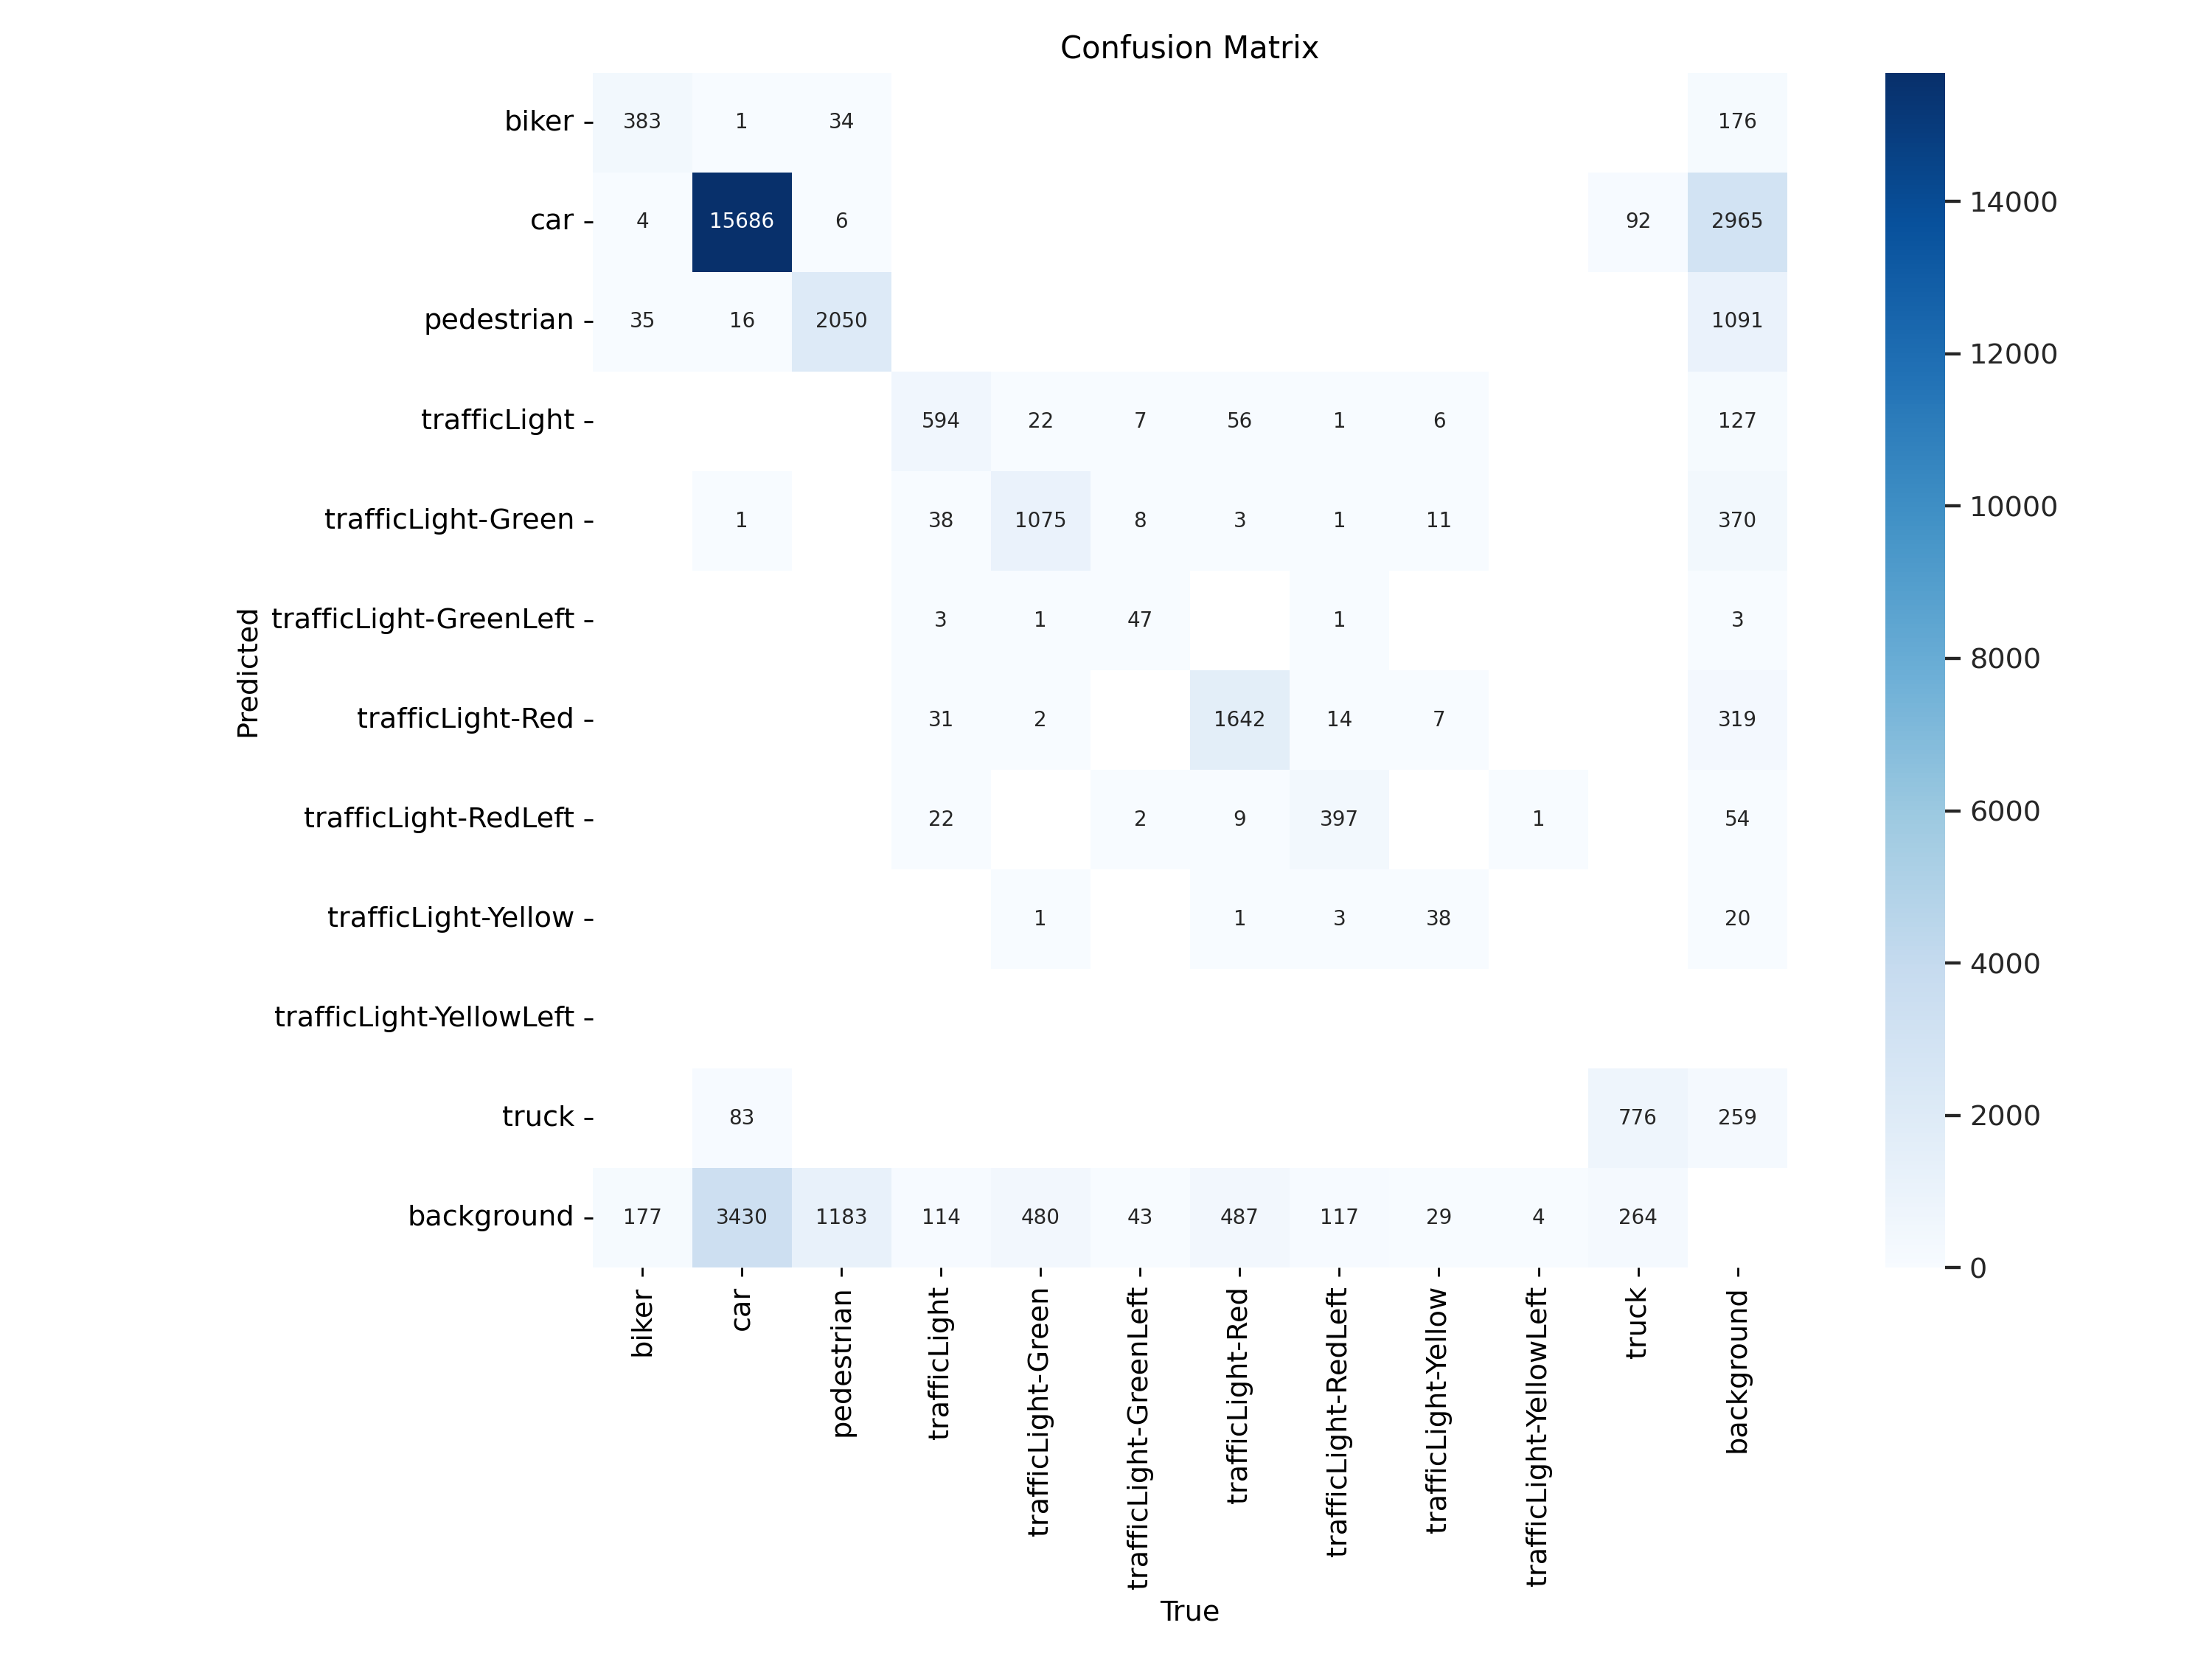

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/datasets/runs/detect/train2/confusion_matrix.png', width=1000)

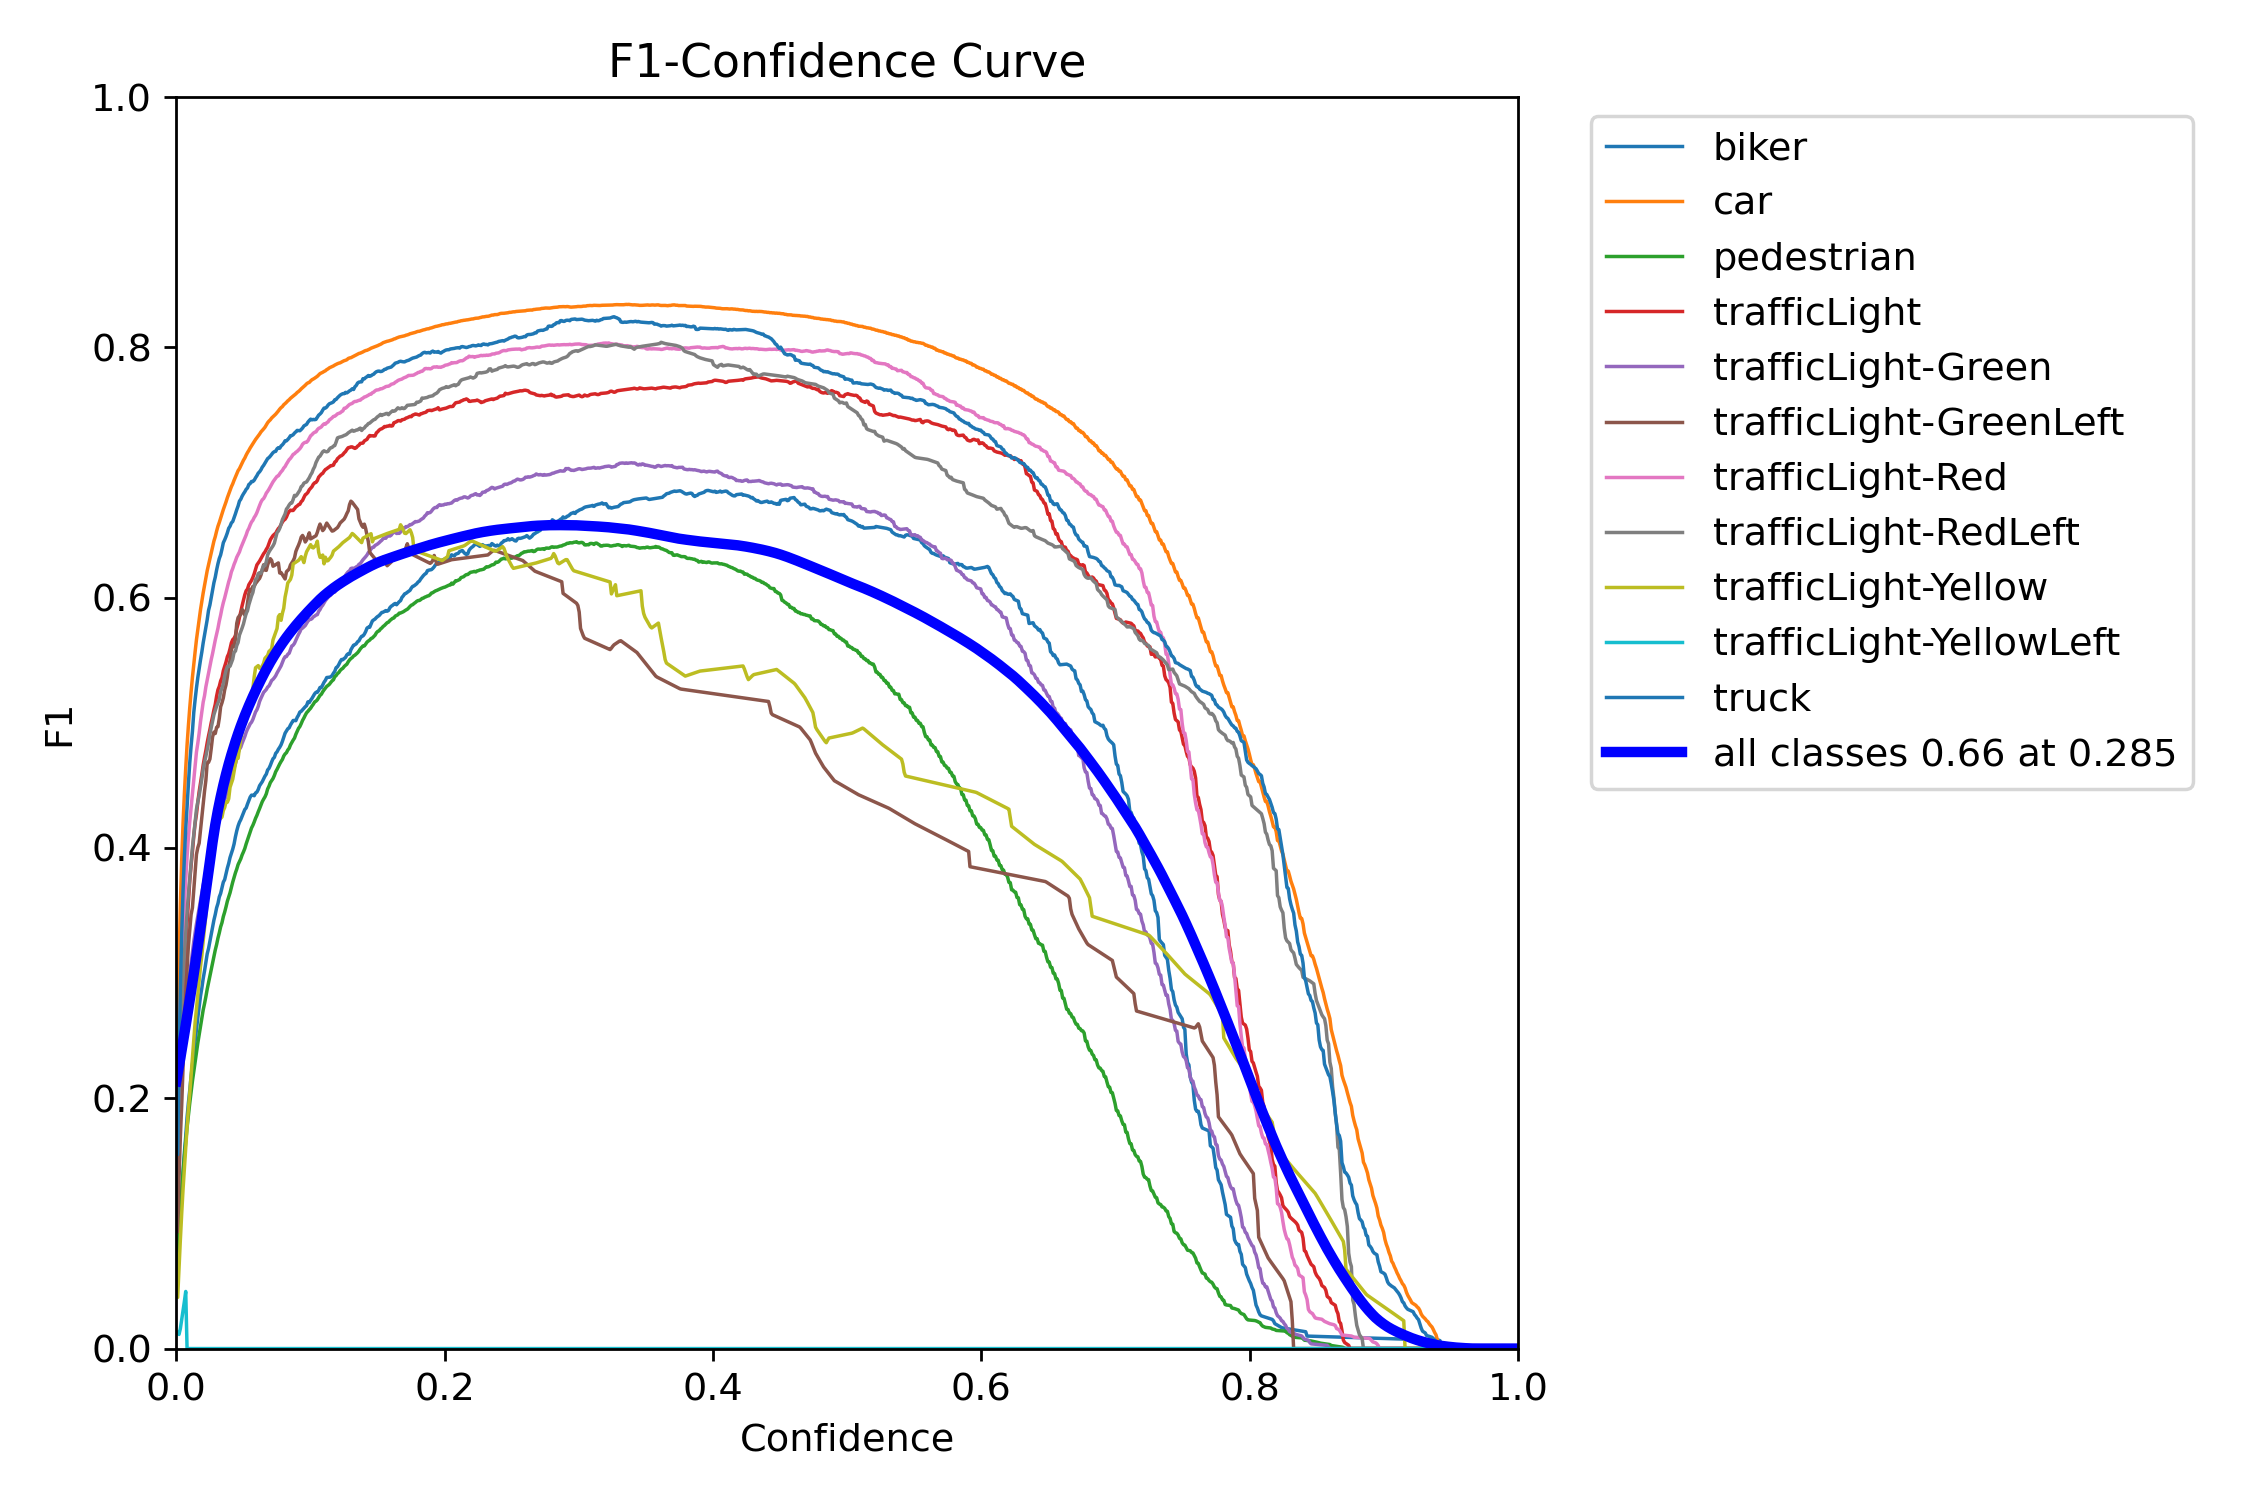

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/datasets/runs/detect/train2/F1_curve.png', width=1000)

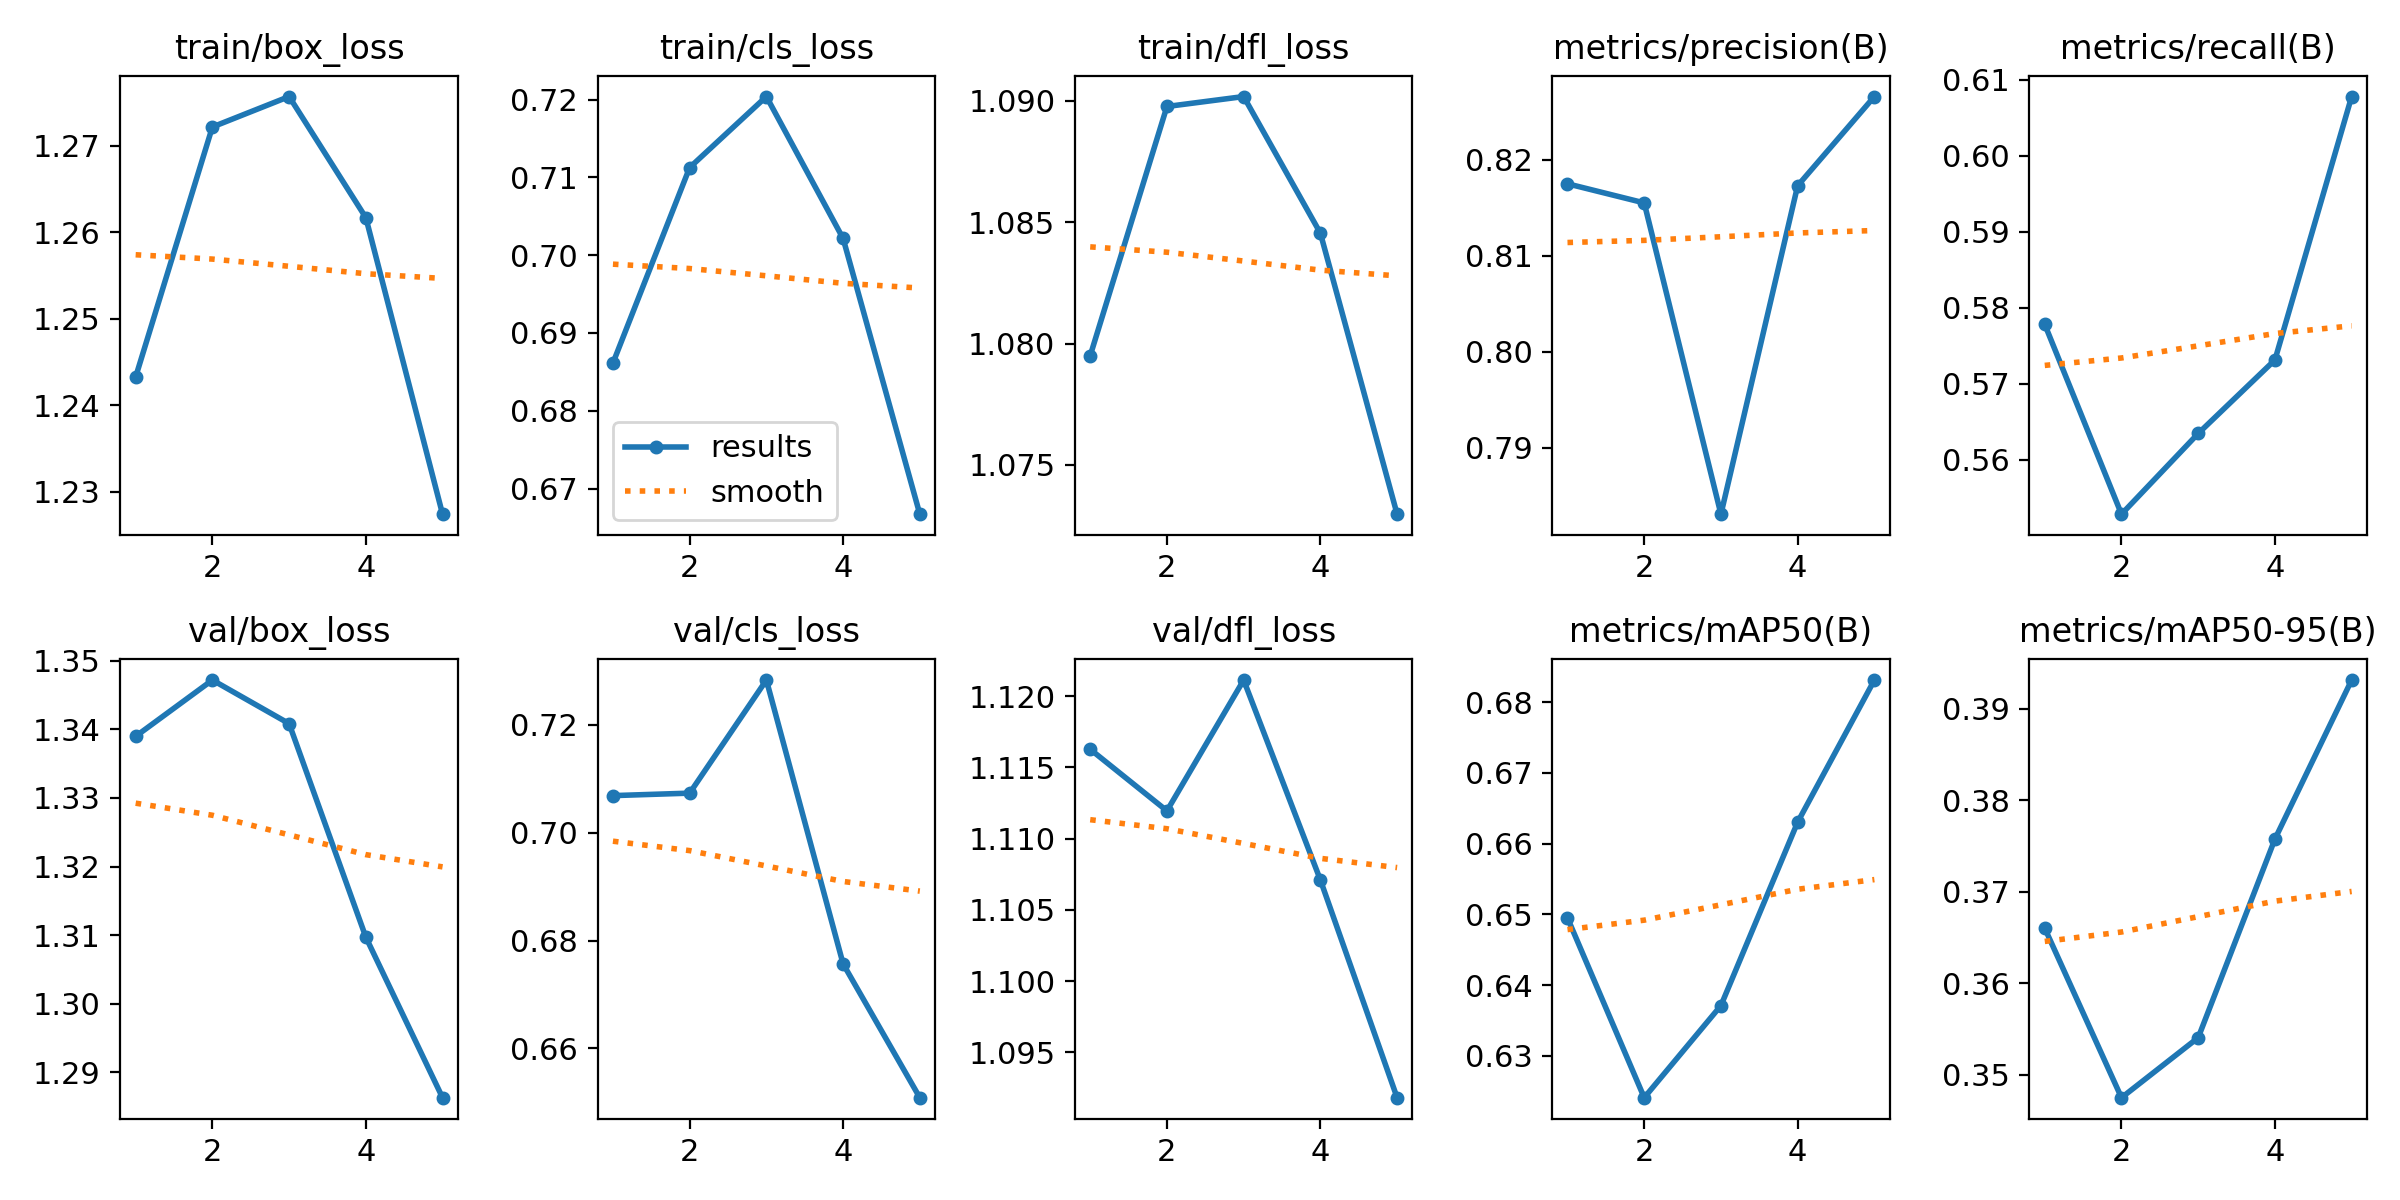

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/datasets/runs/detect/train2/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['biker',
 'car',
 'pedestrian',
 'trafficLight',
 'trafficLight-Green',
 'trafficLight-GreenLeft',
 'trafficLight-Red',
 'trafficLight-RedLeft',
 'trafficLight-Yellow',
 'trafficLight-YellowLeft',
 'truck']

In [ ]:
from supervision.metrics import MeanAveragePrecision
from ultralytics import YOLO

model = YOLO("/content/datasets/runs/detect/train/weights/best.pt")

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.32911773890408413
mAP 50 0.5705247266887266
mAP 75 0.3333613223008645


In [12]:
!yolo task=detect mode=predict model=/content/best.pt conf=0.25 source={dataset.location}/test/images save=True

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,465 parameters, 0 gradients, 19.3 GFLOPs

image 1/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019953689774621_jpg.rf.UpOkvtBppZZaLfvVZ0JX.jpg: 640x640 4 cars, 1 truck, 22.2ms
image 2/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019954186238236_jpg.rf.f8ac6ad31e400d4918ff394f903bb95c.jpg: 640x640 4 cars, 22.2ms
image 3/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019957687018435_jpg.rf.f4d1d5ec89c63e083d0930dd819271d4.jpg: 640x640 5

In [ ]:
import supervision as sv

model = YOLO("/content/datasets/runs/detect/train2/weights/best.pt")

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

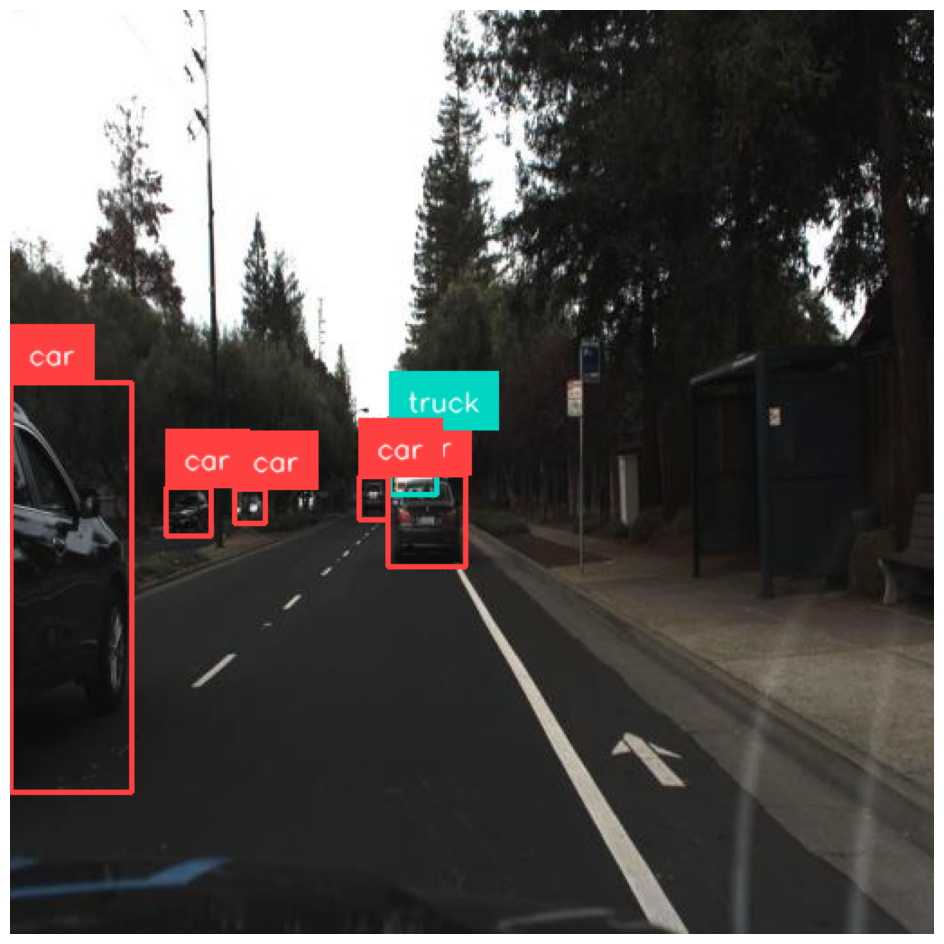

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)